### Project in Deep Learning 2017, Project 5, Eczema vs Psoriasis.
Peter Lunding Jensen and Emilie Brun Knudsen.

Before running the code, go to https://mega.nz/#!4TxThQKB!EstWA3XuyU05TVXLT2ZzWCRlwdD8NOdzFK2_1D6koiU and download the weights, place the file in the tmp folder.

The code below is the initializer for the model. Since the images used for test and traing are restricted (a training set not publicly available) we but the entire framework, but are actually not able to test or train.

In [1]:
from scipy import misc
import numpy as np
import os         
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
import random
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d,dropout
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from spatial_transformer import transformer
from tensorflow.python.ops.nn import relu


EKSEM_TRAIN_DIR = './data/train/eksem/'
PSORIASIS_TRAIN_DIR = './data/train/psoriasis/'
EKSEM_TEST_DIR = './data/test/eksem/'
PSORIASIS_TEST_DIR = './data/test/psoriasis/'
NUM_CLASSES=2
BATCH_SIZE = 14
MAX_STEPS = 1000
NUM_COL_CHANNELS = 3
TEST_DIR = 'test'
IMG_HEIGHT = 630
IMG_WIDTH = 945
OUT_HEIGHT= IMG_HEIGHT // 3
OUT_WIDTH = IMG_WIDTH //3
LEARNING_RATE= 0.000001
MODEL_NAME = 'eksem-psoriasis-model'


#Create training data here:
def create_train_data(batch_size=BATCH_SIZE):
    x_train = []
    y_train = []
    for i in range(batch_size):
        if(bool(random.getrandbits(1))==True):
            path = PSORIASIS_TRAIN_DIR
            y_label = [1,0]
        else:
            path = EKSEM_TRAIN_DIR
            y_label = [0,1]
        random_image = random.choice([x for x in os.listdir(path)
            if os.path.isfile(os.path.join(path, x))])
        img_data = misc.imread(path+random_image)
        img_data = misc.imresize(img_data, (IMG_HEIGHT, IMG_WIDTH)) / 255
        x_train.append(img_data)
        y_train.append(y_label)
    x_train = np.asarray(x_train, dtype="float32")
    x_train = x_train.reshape((batch_size, IMG_HEIGHT, IMG_WIDTH,NUM_COL_CHANNELS))
    y_train = np.asarray(y_train, dtype="float32")
    return x_train, y_train

def create_test_data(batch_size=BATCH_SIZE):
    x_test = []
    y_test = []
    for i in range(batch_size):
        if(bool(random.getrandbits(1))==True):
            path = PSORIASIS_TEST_DIR
            y_label = [1,0]
        else:
            path = EKSEM_TEST_DIR
            y_label = [0,1]
        random_image = random.choice([x for x in os.listdir(path)
            if os.path.isfile(os.path.join(path, x))])
        img_data = misc.imread(path+random_image)
        img_data = misc.imresize(img_data, (IMG_HEIGHT, IMG_WIDTH)) / 255
        x_test.append(img_data)
        y_test.append(y_label)
    x_test = np.asarray(x_test, dtype="float32")
    x_test = x_test.reshape((batch_size, IMG_HEIGHT, IMG_WIDTH,NUM_COL_CHANNELS))
    y_test = np.asarray(y_test, dtype="float32")
    return x_test, y_test

#X_train, Y_train = create_train_data()
#X_test, Y_test = create_test_data()
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

def build_model(x_pl, input_width, input_height, output_dim,
                batch_size):
    
    # make distributed representation of input image for localization network
    loc_l1 = pool(x_pl, kernel_size=[2, 2], scope="localization_l1")
    loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l2")
    loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="localization_l3")
    loc_l4 = conv(loc_l3, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l4")
    loc_l4_flatten = flatten(loc_l4, scope="localization_l4-flatten")
    loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="localization_l5")
    
    # set up weights for transformation (notice we always need 6 output neurons)
    with tf.name_scope("localization"):
        W_loc_out = tf.get_variable("localization_loc-out", [50, 6], initializer=tf.constant_initializer(0.0))
        initial = np.array([[0.45, 0, 0], [0, 0.45, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()
        b_loc_out = tf.Variable(initial_value=initial, name='b-loc-out')
        loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out


    # spatial transformer
    l_trans1 = transformer(x_pl, loc_out, out_size=(OUT_HEIGHT, OUT_WIDTH))
    l_trans1.set_shape([None, OUT_HEIGHT, OUT_WIDTH, NUM_COL_CHANNELS])

    print( "Transformer network output shape: ", l_trans1.get_shape())

    # classification network
    #Blok 1
    conv_l11 = conv(l_trans1, num_outputs=64, kernel_size=[3, 3])
    conv_l12 = conv(conv_l11, num_outputs=64, kernel_size=[3, 3])
    pool_l13 = pool(conv_l12, kernel_size=[2, 2], stride=[2,2])
    #Blok 2   
    #conv_l21 = conv(pool_l13, num_outputs=128, kernel_size=[3, 3])
    #conv_l22 = conv(conv_l21, num_outputs=128, kernel_size=[3, 3])
    #pool_l23 = pool(conv_l22, kernel_size=[2, 2], stride=[2,2])
    #Blok 3    
    #conv_l31 = conv(pool_l13, num_outputs=128, kernel_size=[3, 3])
    conv_l32 = conv(pool_l13, num_outputs=64, kernel_size=[3, 3])
    conv_l33 = conv(conv_l32, num_outputs=64, kernel_size=[3, 3])
    pool_l34 = pool(conv_l33, kernel_size=[2, 2], stride=[2,2])
    #Blok 4    
    conv_l41 = conv(pool_l34, num_outputs=128, kernel_size=[3, 3])
    conv_l42 = conv(conv_l41, num_outputs=128, kernel_size=[3, 3])
    conv_l43 = conv(conv_l42, num_outputs=128, kernel_size=[3, 3])
    pool_l44 = pool(conv_l43, kernel_size=[2, 2], stride=[2,2])
    #Blok 5   
    conv_l51 = conv(pool_l44, num_outputs=256, kernel_size=[3, 3])
    conv_l52 = conv(conv_l51, num_outputs=256, kernel_size=[3, 3])
    conv_l53 = conv(conv_l52, num_outputs=256, kernel_size=[3, 3])
    pool_l54 = pool(conv_l53, kernel_size=[2, 2], stride=[2,2])
     
    dense_flatten = flatten(pool_l54)
    dense_1 = dense(dense_flatten, num_outputs=2048, activation_fn=relu)
    dropout_l4 =dropout(dense_1)
    dense_2 = dense(dropout_l4, num_outputs=2048, activation_fn=relu)
    dropout_l5 =dropout(dense_2)
    logit = dense(dropout_l5, num_outputs=output_dim, activation_fn=None)
    l_out = tf.nn.softmax(logit)

    return l_out,logit,l_trans1, loc_out

tf.reset_default_graph() 

x_pl = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, NUM_COL_CHANNELS], name='input')
y_pl = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='output')
lr_pl = tf.placeholder(tf.float32, shape=[], name="learning-rate")
y_from_model,y_logits,x_transform,location_out = build_model(x_pl, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES,batch_size=BATCH_SIZE)

print('Model consits of ', utils.num_params(), 'trainable parameters.')


with tf.variable_scope('loss'):
    #cross_entropy = -tf.reduce_sum(y_pl * tf.log(y_from_model+1e-8), reduction_indices=[1])
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_pl,logits=y_logits)
    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)
    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)
    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)
    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y_from_model, axis=1), tf.argmax(y_pl, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
step = 0
saver = tf.train.Saver()

Transformer network output shape:  (?, 210, 315, 3)
Model consits of  150481934 trainable parameters.


Actual training code. It is not runnable due to the data not being available to the public.

In [ ]:
#Training loop
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess_train:
    sess_train.run(tf.global_variables_initializer())
    saver.restore(sess_train, "./tmp/model_ADAM_stor_vgg16.ckpt")
    save_path = saver.save(sess_train, "./tmp/model_ADAM_vgg16_stor_backup.ckpt")
    print("Model restored.")
    print('Begin training loop')
    
    while step < MAX_STEPS:
        step=step+1
        _train_loss, _train_accuracy = [], []
        
        ## Run train op
        x_batch, y_batch = create_train_data(BATCH_SIZE)
        fetches_train = [train_op, cross_entropy, accuracy, y_from_model]
        feed_dict_train = {x_pl: x_batch, y_pl: y_batch, lr_pl: LEARNING_RATE}
        _, _loss, _acc,y_res = sess_train.run(fetches_train, feed_dict_train)
        print(_loss)
        print(_acc)
        print(step)
        #print(y_res)
        if(step % 1000 ==0):
            LEARNING_RATE = LEARNING_RATE/2
            print("New LR is %f" %LEARNING_RATE)
            
    save_path = saver.save(sess_train, "./tmp/model_ADAM_stor_vgg16.ckpt")
    print("Model saved.")


Forward pass from the model. We print both the orginal image, the output from the STN and the transformation matrix. The two images used here are images from google image search. Normally create_test_data() would be used.

To test with other images (e.g from google image search), use the flask homepage tool build for this. Or rewrite the create_showcase_data handler to take custom input (or as a interim solution, add the images to the showcase folders).
Run a cuple of times to get different results.

INFO:tensorflow:Restoring parameters from ./tmp/model_ADAM_stor_vgg16.ckpt


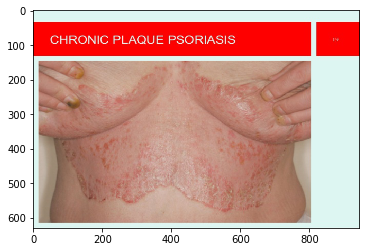

[ 0.50226152  0.00617632 -0.00124629]
[-0.00395307  0.50444025  0.00208598]


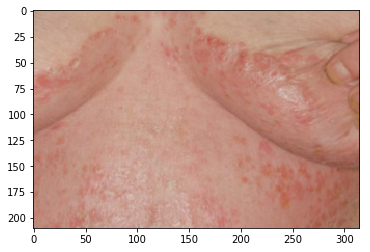

Prediction : Psoriasis
0.721926
True : Psoriasis
Confidence is: [ 0.27807358  0.72192639]


In [15]:
EKSEM_SHOWCASE_DIR = './showcase/eksem/'
PSORIASIS_SHOWCASE_DIR = './showcase/psoriasis/'

def create_showcase_data(batch_size=BATCH_SIZE):
    x_train = []
    y_train = []
    for i in range(batch_size):
        if(bool(random.getrandbits(1))==True):
            path = PSORIASIS_SHOWCASE_DIR
            y_label = [1,0]
        else:
            path = EKSEM_SHOWCASE_DIR
            y_label = [0,1]
        random_image = random.choice([x for x in os.listdir(path)
            if os.path.isfile(os.path.join(path, x))])
        img_data = misc.imread(path+random_image)
        img_data = misc.imresize(img_data, (IMG_HEIGHT, IMG_WIDTH)) / 255
        x_train.append(img_data)
        y_train.append(y_label)
    x_train = np.asarray(x_train, dtype="float32")
    x_train = x_train.reshape((batch_size, IMG_HEIGHT, IMG_WIDTH,NUM_COL_CHANNELS))
    y_train = np.asarray(y_train, dtype="float32")
    return x_train, y_train

x_pred, y_pred = create_showcase_data(1)
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model_ADAM_stor_vgg16.ckpt")
    x_pred = x_pred[0].reshape(1,IMG_HEIGHT,IMG_WIDTH,3)
    fetches_val = [y_from_model,x_transform,location_out]
    feed_dict_val = {x_pl: x_pred}
    res, x_trans,locout = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
    output_eval = res
    
    plt.imshow(np.squeeze(x_pred))
    plt.show()
    print(locout[0][0:3])
    print(locout[0][3:6])
    plt.imshow(np.abs(np.squeeze(x_trans)))
    plt.show()
    
    if(output_eval[0][0] > 0.5):
        print("Prediction : Eksem")
        print(output_eval[0][0])
    else:
        print("Prediction : Psoriasis")
        print(output_eval[0][1])

    if(y_pred[0][0] == 0.0):
        print("True : Eksem")
    else:
        print("True : Psoriasis")
print("Confidence is: "+str(output_eval[0]))

